<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/04_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представим, что сегодня 31 января 2023 года, и мы хотим помочь определить рыночную цену продавцам, которые собираются сегодня разместить свои объявления. Рынок автомобилей меняется довольно быстро, поэтому в этом кейсе будем обучать нашу модель только на объявлениях, которые были размещены вчера. Будем считать, что такие объявления лучше всего отражают текущую ситуацию на рынке.

Напишите запрос, чтобы выгрузить данные об объявлениях, опубликованных за 30 января 2023 года. Помимо объявлений нам понадобится признак пользователей `user_type_cars_name` из таблицы `user_passports` - присоедините его к таблице `live_adverts`.

Данные нужно получить из доступных в Clickhouse таблиц `live_adverts` и `user_passports`. Джойнить будем по равенству поля `user_id` из `live_adverts` и поля `global_id` из `user_passports`.

Сколько строк у вас получилось в датасете?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.7/935.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
#
sql = """
SELECT
  la.*,
  up.user_type_cars_name
FROM
  dp_live_adverts la
LEFT JOIN user_passports up on la.user_id = up.global_id
WHERE
  la.created_at::date = '2023-01-30'

"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
print(f"в датасете {data.shape[0]} записей")

в датасете 36043 записей


## Задача 1. Предобработка данных (1/6)

В первую очередь обратим внимание на типы полей, а конкретно на поле “год выпуска машины”? Будет ли нам удобно анализировать его в таком виде? Если нет, то поменяйте тип поля.

В поле ниже укажите текущий тип поля или новый, если тип поля следует изменить. Тип в ответе пишите строчными (маленькими) буквами.

In [ ]:
data.year = data.year.astype('int')

In [ ]:
data.year.dtype

dtype('int64')

## Задача 1. Предобработка данных (2/6) ##


Обратим внимание, какое минимальное значение года выпуска автомобиля в нашем датасете? Адекватно ли на ваш взгляд это значение?

Мы могли бы заменить это значение на np.nan и работать с ним как с пропуском. Но в данном случае поступим проще: удалим все строки с таким значением года.

Какое минимальное значение было у года?

In [ ]:
data.year.min()

0

In [ ]:
data = data[data.year != 0].copy()

In [ ]:
data.year.min()

1950

## Задача 1. Предобработка данных (3/6)
Какие поля мы точно не сможем использовать в качестве признаков при построении модели, из-за того, что значения либо уникальные, либо одинаковые для всех объектов?

Для воспроизводимости результатов перед удалением этих столбцов отсортируйте датафрейм по ['execution_date', 'advert_id']

In [ ]:
data.sort_values(by=['execution_date', 'advert_id'], inplace=True)

In [ ]:
data = data.drop(['execution_date', 'passport_id',
                'advert_id', 'user_id', 'created_at'], axis=1).reset_index(drop=True)

In [ ]:
data

,price,region,platform,auto_brand,auto_model,year,userType,user_type_cars_name
0,414000,Самара,ios,ЗАЗ,Chance,2014,0,cars_simple
1,620000,Сочи,ios,Chevrolet,Cruze,2010,0,cars_simple
2,4970000,Москва,android,Toyota,Land Cruiser,2013,6,cars_seller
3,800000,Москва,android,Subaru,Impreza,2006,0,cars_simple
4,280000,Пермь,android,Mitsubishi,RVR,1995,0,cars_simple
...,...,...,...,...,...,...,...,...
33275,10000,Новосибирск,android,Unknown,Unknown model,2007,0,cars_simple
33276,480000,Новосибирск,ios,ВАЗ (Lada),Priora 2170 (седан),2012,0,cars_simple
33277,1320000,Новосибирск,android,Chevrolet,Cobalt,2021,0,cars_simple
33278,740000,Москва,desktop,Mercedes-Benz,C 320,2002,0,cars_simple


## Задача 1. Предобработка данных (4/6)


Один из оставшихся категориальных признаков содержит большое количество уникальных значений, что приведет к слишком разреженному датасету при применении one hot encoding и будет только ухудшать качество модели. Поэтому его нужно удалить.

Что это за признак?

In [ ]:
data.nunique().sort_values()[:-1].idxmax()

'auto_model'

In [ ]:
data.drop(data.nunique().sort_values()[:-1].idxmax(), axis=1, inplace=True)

In [ ]:
data.head()

,price,region,platform,auto_brand,year,userType,user_type_cars_name
0,414000,Самара,ios,ЗАЗ,2014,0,cars_simple
1,620000,Сочи,ios,Chevrolet,2010,0,cars_simple
2,4970000,Москва,android,Toyota,2013,6,cars_seller
3,800000,Москва,android,Subaru,2006,0,cars_simple
4,280000,Пермь,android,Mitsubishi,1995,0,cars_simple


## Задача 1. Предобработка данных (5/6)


Есть и ещё одна колонка, которую можно не брать в качестве признака. Какая?

In [ ]:
data = data.drop(['userType'], axis=1)

## Задача 1. Предобработка данных (6/6)


Если вы построите распределение цены автомобилей (это можно сделать с помощью `sns.histplot`), то увидите, что распределение далеко не нормальное. Это плохо, потому что наша модель будет стараться подстроиться под аномальные значения, и в итоге потеряет свою обобщающую способность.

Попробуем сделать распределение более симметричными с помощью удаления выбросов. Давайте будем считать, что цена на автомобиль меньше 1000 – это аномально низкое значение.

Можно заметить, что даже после удаления аномально низких значений распределение не стало сильно лучше. В таком случае часто применяется логарифмирование. С помощью применения функции логарифма `np.log` к таргету мы сможем добиться распределения, близкого к нормальному. Это допустимое действие, поскольку логарифмирование – это монотонное преобразование, то есть мы просто переводим наш таргет в другую шкалу – логарифмическую. Создайте признак `log_price`

Постройте гистограмму нового распределения цены.

И прежде чем переходить к созданию пайплайна и обучению модели, давайте убедимся, что наши датасеты совпадают.

Сколько строк осталось в датасете после очистки от выбросов?

In [ ]:
data = data[data.price >= 1000].copy()

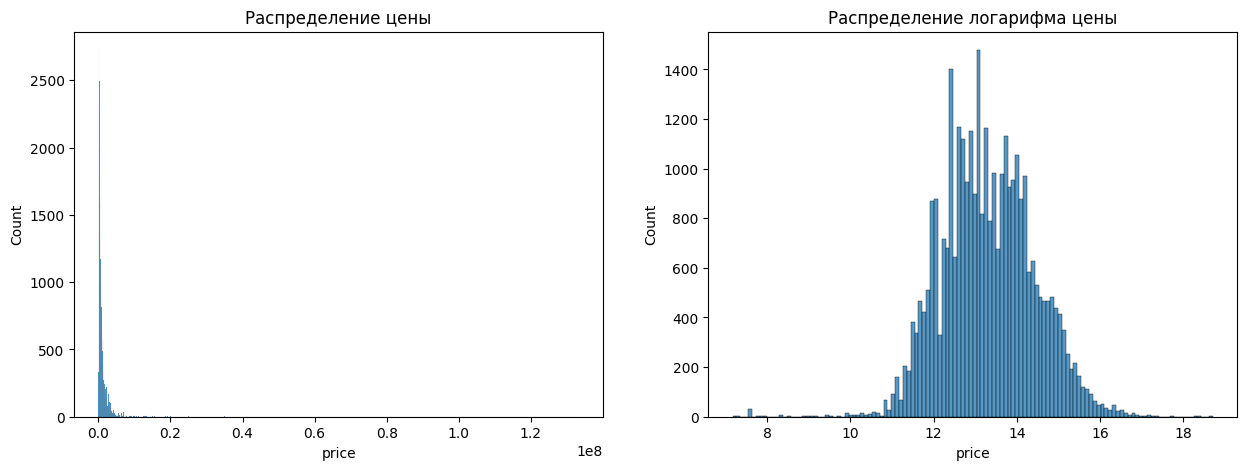

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(data.price, ax=axes[0]).set_title('Распределение цены')
sns.histplot(np.log(data.price), ax=axes[1]).set_title("Распределение логарифма цены");

In [ ]:
print(f"осталось {data.shape[0]} строк")

осталось 33070 строк


In [ ]:
data['log_price'] = data.price.apply(np.log)
data.drop('price', axis=1, inplace=True)

## Задача 2. Автоматическая обработка данных


Разделим признаки на категориальные и числовые и определим X и y. Причём помним, что в качестве таргета y мы используем логарифм цены.

Затем вам нужно будет разделить данные на обучающую и валидационную выборку.  Используйте `train_test_split`, тренировочная и тестовая выборка в соотношении 80% и 20%, `random_state=42` для воспроизводимости результата.

В этом задании мы будем использовать самый простой вариант: OneHotEncoder для всех категориальных признаков и `StandardScaler` для всех числовых. Для решения задания используйте такой вариант. В качестве дополнительного упражнения можете попробовать более сложные подходы, например `TargetEncoder` или автоматический выбор между `OneHotEncoder` и `TargetEncoder`, как мы делали в уроке 2.

Создайте `ColumnTransformer`, преобразующий все признаки в соответствии с их типом.

Создайте `Pipeline` с `ColumnTransformer`-ом и `KNeighborsRegresso`r с дефолтными параметрами. Установите `n_jobs=1` для воспроизводимости результатов.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import make_column_selector as selector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [ ]:
ohe = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
std_sc = StandardScaler()

In [ ]:
col_transformer = ColumnTransformer(
    transformers=[("OneHotEncoder", ohe, selector(dtype_exclude="number")),
                  ("StandardScaler", std_sc, selector(dtype_include="number"))],
    verbose_feature_names_out=False,

).set_output(transform='pandas')



In [ ]:
col_transformer.fit_transform(data.drop('log_price', axis=1))

,region_Воронеж,region_Екатеринбург,region_Ижевск,region_Казань,region_Калининград,region_Краснодар,region_Красноярск,region_Москва,region_Нижний Новгород,region_Новосибирск,...,auto_brand_ИЖ,auto_brand_ЛуАЗ,auto_brand_Москвич,auto_brand_Ретро-автомобили,auto_brand_ТагАЗ,auto_brand_УАЗ,user_type_cars_name_cars_dealer,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.909204
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.511826
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.809860
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.114449
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.978340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.213793
33276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.710515
33277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.604615
33278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.282929


In [ ]:
pipe_knn = Pipeline(
    [
        ("col_transformer", col_transformer),
        ("KNeighborsRegressor", KNeighborsRegressor(n_jobs=1))
    ]
)

In [ ]:
X = data.drop('log_price', axis=1)
y = data.log_price
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

## Задача 3. Выбор метрик (1/2)


Для измерения качества модели будем использовать следующие метрики:

`r2_score` - метрика со значением от 0 до 1. Показывает долю дисперсии целевой переменной, которую объясняет наша модель. Чем она выше, тем лучше. Может быть отрицательной, если наша модель работает хуже наивного прогноза.
`mean_absolute_error`

Таким образом, чем ниже значение `MAE`, тем лучше.

Запустите пайплайн на обучающей выборке и измерьте качество предсказания на валидационной выборке с помощью выбранных нами метрик.

В поле ниже укажите значение метрики `R2`, округленное до сотых. Используйте точку в качестве разделителя целой и десятичной части.



In [ ]:
R2 = r2_score(y_test, pipe_knn.fit(X_train, y_train).predict(X_test))
print(f"R-squared score: {R2:.2f}")

R-squared score: 0.72


## Задача 3. Выбор метрик (2/2)


В поле ниже укажите значение метрики `MAE`, округленное до сотых. Используйте точку в качестве разделителя целой и десятичной части.



In [ ]:
MAE = mean_absolute_error(y_test, pipe_knn.fit(X_train, y_train).predict(X_test))
print(f"Mean absolute error: {MAE:.2f}")

Mean absolute error: 0.39


In [ ]:
np.corrcoef(y_test, pipe_knn.fit(X_train, y_train).predict(X_test))
#

array([[1.        , 0.84798811],
       [0.84798811, 1.        ]])

## Задача 4. Подбор гиперпараметров для kNN (1/2)


Воспользуемся метрикой и подберем гиперпараметры для модели с помощью знакомого нам GridSearchCV.

Будем подбирать количество соседей, тип весов и параметр p – степень в метрике расстояния Минковского.

* для количества соседей используйте варианты из `np.linspace(1, 30, 5, dtype=int)`.
* для типов весов - варианты `'uniform'` и `'distance'`.
* для `p: 1, 2`.
* в качестве данных для `GridSearchCV` используйте обучающую выборку.
* в качестве метрики будем использовать `R2`.

In [ ]:
### Сделаем сетку с параметрами
knn_grid = {
    'KNeighborsRegressor__n_neighbors': np.linspace(1, 30, 5, dtype=int),
    'KNeighborsRegressor__weights': ['uniform', 'distance'],
    'KNeighborsRegressor__p': [1, 2]
}

In [ ]:
### KNN
print("Поиск лучших параметров KNN:")
search_knn = GridSearchCV(pipe_knn, knn_grid,
                         cv=None, scoring='r2', return_train_score=True)

search_knn.fit(X_train, y_train)

print(f"Best parameter (CV score={search_knn.best_score_:.5f}):")
print(search_knn.best_params_)

Поиск лучших параметров KNN:
Best parameter (CV score=0.79443):
{'KNeighborsRegressor__n_neighbors': 30, 'KNeighborsRegressor__p': 2, 'KNeighborsRegressor__weights': 'distance'}


Best parameter (CV score=0.79443):
{'KNeighborsRegressor__n_neighbors': 30, 'KNeighborsRegressor__p': 2, 'KNeighborsRegressor__weights': 'distance'}

## Задача 4. Подбор гиперпараметров для kNN (2/2)


Обучите модель с найденными гиперпараметрами на обучающей выборке. Проверьте качество на тестовой выборке. Сравните с тем, что у нас получалось без указания гиперпараметров в степе 10.

На сколько процентов улучшилась метрика R-square?

Введите значение, округленное до целого числа, без знака % в поле ниже.

In [ ]:
pipe_knn.set_params(**search_knn.best_params_)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('OneHotEncoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f917ade3b80>),
                                                 ('StandardScaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9176605420>)],
                                   verbose_feature_names_out=False)),
                ('KNeighborsRegressor',
                 KNeighborsRegressor(n_jobs=1, n_neighbors=30,
                                     weights='distance'))])

In [ ]:
y_ = pipe_knn.fit(X_train, y_train).predict(X_test)

In [ ]:
r2_new = r2_score(y_test, y_)

In [ ]:
print(f'R-squared score: {r2_new:.2f}')

R-squared score: 0.81


In [ ]:
print(f"R-square улучшилась на {(r2_new - R2)/R2:.2%}")

R-square улучшилась на 13.15%
